# Optimal lumped mass matrix for the FEM

In [1]:
from __future__ import division
from sympy import *
from sympy import symbols
from sympy.matrices import *
import numpy as np

r, s, t, lamda = symbols('r s t lambda') 
x0, x1, x2, x3, x4, x5, x6, x7 = symbols('x0 x1 x2 x3 x4 x5 x6 x7')
y0, y1, y2, y3, y4, y5, y6, y7 = symbols('y0 y1 y2 y3 y4 y5 y6 y7')
init_printing()

In [2]:
def mat_fun(M, fun):
    """Compute the matrix-function for M
    
    Parameters
    ----------
    M : (n,n) matrix
        (Invertible) Square matrix.
    fun : Python function
        Function to be applied to the matrix.
    
    >>> M = Matrix([
    ...[4, 0, 2, 0, 1, 0, 2, 0],
    ...[0, 4, 0, 2, 0, 1, 0, 2],
    ...[2, 0, 4, 0, 2, 0, 1, 0],
    ...[0, 2, 0, 4, 0, 2, 0, 1],
    ...[1, 0, 2, 0, 4, 0, 2, 0],
    ...[0, 1, 0, 2, 0, 4, 0, 2],
    ...[2, 0, 1, 0, 2, 0, 4, 0],
    ...[0, 2, 0, 1, 0, 2, 0, 4]])
    >>> print mat_fun(M, exp) - exp(M)
    Matrix([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]])
    """
    sol = M.eigenvects()
    n = M.shape[0]
    vals = zeros(n)
    vecs = zeros(n)

    cont = 0
    for i in range(len(sol)):
        for k in range(sol[i][1]):
            vals[cont, cont] = fun(sol[i][0])
            vecs[:, cont] = sol[i][2][k]
            cont = cont + 1
    
    return vecs*vals*vecs.inv()

In [3]:
def mat_norm(A):
    r"""Compute the norm of a matrix
    
    The norm is given by
    .. math::
        \Vert A\Vert = [\text{tr}{A^T A}]^{1/2}
   
    Parameters
    ----------
    A : (n,n) Matrix
        Real matrix.

    Returns
    -------
    norm : nonnegative
        Norm of the matrix.

    """
    
    norm = sqrt((A.T*A).trace())
    return simplify(norm)

In [4]:
def mat_dist(A, B, dist="frob"):
    r"""Compute the distant function for the tensor `A` and `B`

    The distance functions are
    
    .. math::
        \begin{align}
        &d_F(A,B) = \Vert A - B\Vert\\
        &d_L(A,B) = \Vert \log{A} - \log{B}\Vert\\
        &d_R(A,B) = \Vert \log{A^{-1/2}BA^{1/2}}\Vert
        \end{align}

    where :math:`\Vert M\Vert = [\text{tr}{M^T M}]^{1/2}`. 

    References
    ----------
    .. [1] Norris, Andrew. "The isotropic material closest to a given
        anisotropic material." Journal of Mechanics of Materials and
        Structures 1.2 (2006): 223-238.

    .. [2] Moakher, Maher, and Andrew N. Norris. "The closest elastic
        tensor of arbitrary symmetry to an elasticity tensor of lower
        symmetry." Journal of Elasticity 85.3 (2006): 215-263.

    """

    if dist=="frob":
        C = A - B

    if dist=="riemman":  # This is too slow
        C = B*mat_fun(A, sqrt)
        C = mat_fun(A, lambda x: S(1)/sqrt(x))*C
        C = mat_fun(C, log)
        
    if dist=="log":
        C = mat_fun(A, log) -  mat_fun(B, log)
    
    return  mat_norm(C)

The mass matrix is computed below

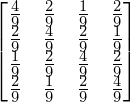

In [5]:
H = S(1)/4*Matrix([(1 + r)*(1 + s),
         (1 - r)*(1 + s),
         (1 - r)*(1 - s),
         (1 + r)*(1 - s)])
 
M_int = H*H.T

M = zeros(4,4)
for i in range(4):
    for j in range(4):
        M[i,j] = integrate(M_int[i,j],(r,-1,1), (s,-1,1))

M

In [6]:
Ms = symbols('M0:%d'%4)

def f(i,j):
    if i == j:
        return Ms[i]
    else:
        return 0
    
M_diag = Matrix(4, 4, f)

## Unconstrained optimization

### Frobenius distance

In [7]:
dist_sq = mat_dist(M_diag, M)**2

In [8]:
grad = [diff(dist_sq, x) for x in Ms]

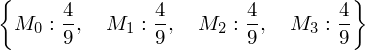

In [9]:
solve(grad, Ms)

### Log-Euclidean distance

In [10]:
dist_sq = mat_dist(M_diag, M, dist='log')**2

In [11]:
grad = [diff(dist_sq, x) for x in Ms]

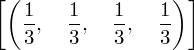

In [12]:
solve(grad, Ms)

### Riemmanian distance

In [13]:
dist_sq = mat_dist(M_diag, M, dist='riemman')**2

In [14]:
grad = [diff(dist_sq, x) for x in Ms]

## Constrained optimization

In [15]:
f = mat_dist(M_diag, M)**2 + lamda*(4 - sum(Ms))

var = list(Ms)
var.append(lamda)

In [16]:
grad = [diff(f, x) for x in var]

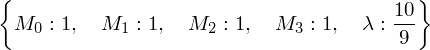

In [17]:
solve(grad, var)

## Distorted element

In [18]:
coords = Matrix([
 [x0,x1,x2,x3], 
 [y0,y1,y2,y3]
])

In [19]:
dNdr = Matrix(4,2, lambda i,j: diff(H[i], [r,s][j]))
jac = coords*dNdr
detjac = jac.det()

area = integrate(detjac,(r,-1,1), (s,-1,1))

In [20]:
M_int = H*H.T

M = zeros(4,4)
for i in range(4):
    for j in range(4):
        M[i,j] = integrate(M_int[i,j]*detjac,(r,-1,1), (s,-1,1))

In [21]:
f = mat_dist(M_diag, M)**2 + lamda*(area - sum(Ms))

var = list(Ms)
var.append(lamda)

In [22]:
grad = [diff(f, x) for x in var]

And the solution is given by

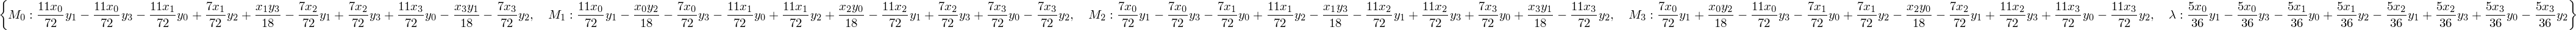

In [23]:
sol = solve(grad, var)
sol

We can check that we recover the solution for the undistorted case

In [24]:
coords_undist = {x0:-1, x1:1, x2:1, x3:-1, y0:-1, y1:-1, y2:1, y3:1}

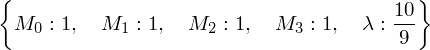

In [25]:
sol_undist = {key:sol[key].subs(coords_undist) for key in sol.keys() for val in sol.values()}
sol_undist

And also for some distorted cases...

In [26]:
coords_dist = {x0:-2, x1:1, x2:1, x3:-1, y0:-2, y1:-1, y2:1, y3:1}

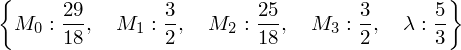

In [27]:
sol_dist = {key:sol[key].subs(coords_dist) for key in sol.keys() for val in sol.values()}
sol_dist

And the sum of the elements is the same the area

In [28]:
area.subs(coords_dist)

The diagonal scaling method would give

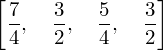

In [29]:
M2 = M.subs(coords_dist)
M2 = M2*area.subs(coords_dist)/M2.trace()
[M2[i,i] for i in range(4)]

And the row summing gives

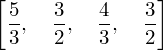

In [30]:
M2 = M.subs(coords_dist)
[sum(M2[i,:]) for i in range(4)]


We can see that some values are the same...

## Eight nodes element

In [31]:
Haux  = S(1)/2*Matrix([(1-r**2)*(1+s),(1-s**2)*(1-r),(1-r**2)*(1-s),(1-s**2)*(1+r)])
H = S(1)/4*Matrix(
    [(1 + r)*(1 + s) - S(1)/2*Haux[0] - S(1)/2*Haux[3],
    (1 - r)*(1 + s)- S(1)/2*Haux[0] - S(1)/2*Haux[1],
    (1 - r)*(1 - s)- S(1)/2*Haux[1] - S(1)/2*Haux[2],
    (1 + r)*(1 - s)- S(1)/2*Haux[2] -S(1)/2*Haux[3],
    Haux[0], Haux[1], Haux[2], Haux[3]])
 
M_int = H*H.T

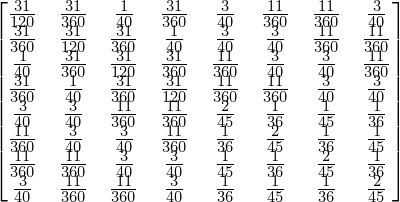

In [32]:
M = zeros(8,8)
for i in range(8):
    for j in range(8):
        M[i,j] = integrate(M_int[i,j],(r,-1,1), (s,-1,1))

M

In [33]:
Ms = symbols('M0:%d'%8)

def f(i,j):
    if i == j:
        return Ms[i]
    else:
        return 0
    
M_diag = Matrix(8, 8, f)

In [34]:
dist_sq = mat_dist(M_diag, M)**2

In [35]:
grad = [diff(dist_sq, x) for x in Ms]

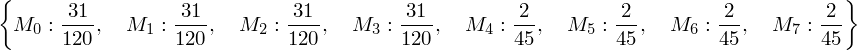

In [36]:
solve(grad, Ms)

### Constrained optimization

In [37]:
f = mat_dist(M_diag, M)**2 + lamda*(4 - sum(Ms))

var = list(Ms)
var.append(lamda)

In [38]:
grad = [diff(f, x) for x in var]

In [39]:
sol = solve(grad, var)

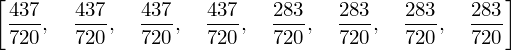

In [40]:
[sol[key] for key in Ms]

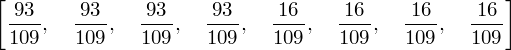

In [41]:
M2 = M*4/M.trace()
[M2[i,i] for i in range(8)]

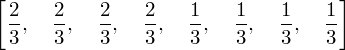

In [42]:
[sum(M[i,:]) for i in range(8)]

### Distorted element

In [43]:
coords = Matrix([
 [x0,x1,x2,x3,x4,x5,x6,x7], 
 [y0,y1,y2,y3,y4,y5,y6,y7]
])

In [50]:
dNdr = Matrix(8,2, lambda i,j: diff(H[i], [r,s][j]))
jac = coords*dNdr
detjac = jac.det()

In [53]:
M_int = (H*H.T)*detjac

In [57]:
area = integrate(detjac,(r,-1,1), (s,-1,1))

M_int = simplify((H*H.T)*detjac)

M = zeros(8,8)
for i in range(8):
    for j in range(8):
        
        M[i,j] = integrate(M_int[i,j],(r,-1,1), (s,-1,1))

f = mat_dist(M_diag, M)**2 + lamda*(area - sum(Ms))

var = list(Ms)
var.append(lamda)

grad = [diff(f, x) for x in var]

sol = solve(grad, var)
sol

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()